<a href="https://colab.research.google.com/github/YulieRu/Complete-flow-characterization-from-snapshot-PIV-fast-probes-and-physics-informed-neural-networks/blob/main/454exp_k_eps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing necessary libraries

In [ ]:
import torch
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn

import numpy as np
import pandas as pd

import os

from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.interpolate import griddata
from collections import OrderedDict
import scipy
from scipy.optimize import curve_fit

import zipfile, io, os, sys

import requests, sys
import urllib.parse
from urllib.parse import urlencode
import gc

import glob

from IPython.display import clear_output

In [ ]:
%pip install -U neptune
clear_output()

In [ ]:
import neptune

In [ ]:
%pip install yadisk
clear_output()

In [ ]:
import yadisk

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# functions for loading data from Yandex.Disk

def getZipDirs(zip_f, isRootDirOnly = False, addPath = True):
  dirs = []
  for f in zip_f.namelist():
    zinfo = zip_f.getinfo(f)
    if zinfo.is_dir():
      if isRootDirOnly:     # Only root directories:
        # This is will work in any OS because the zip format specifies a forward slash.
        r_dir = f.split('/')
        r_dir = r_dir[0]
        if r_dir not in dirs:
          dirs.append(r_dir)
      else: # All directories:
          dirs.append(f)
  if addPath:
    for dir in dirs:
      sys.path.append(os.path.abspath(dir + "/"))
  return dirs

def loadTextFromYandexDisk(url: str, isZip = False):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=url))
  response = requests.get(final_url)
  download_url = response.json()['href']
  download_response = requests.get(download_url)

  if isZip:
    zip = zipfile.ZipFile(io.BytesIO(download_response.content))
    dirs = getZipDirs(zip, True)
    zip.extractall()
  else:
    download_response.encoding = download_response.apparent_encoding
    return download_response.text

def loadData(ref):
  return loadTextFromYandexDisk(ref, isZip=True)

# Properties of air (eta_mol,Cp_det, lam_mol)

In [ ]:
def eta_mol(T): #K-> Pa*s
    return -8.38278e-7+8.35717342e-8*T-7.69429583e-11*(T**2)+4.6437266E-14*(T**3)-1.06585607e-17*(T**4)

def Cp_det(T): #K
    return 1047.63657-0.372589265*T+9.45304214E-4*(T**2)-6.02409443E-7*(T**3)+1.2858961E-10*(T**4)

def rho_def(T, pA=1e5): #K
    R_const = 8.3145
    M_mol = 0.02897
    return pA*M_mol/R_const/T

def lam_mol(T): #K
    return -0.00227583562+1.15480022E-4*T-7.90252856E-8*(T**2)+4.11702505E-11*(T**3)-7.43864331E-15*(T**4)

# 0. Parameters of the experiment

In [ ]:
numExp="453"

In [ ]:
y = yadisk.YaDisk(token='y0__xCpnP6iqveAAhiN7zgg7Y2U4xMbtOa7DcZGFc4NYlvdMBsWG9pZbw')

# Проверка токена
if y.check_token():
    print("valid")
else:
    raise Exception("error")

valid


In [ ]:
print(numExp)
folder_path = "/NN_project/2_PINN/"+numExp+"exp"

if not y.exists(folder_path):
    y.mkdir(folder_path)
    print('the folder have created')

453


In [ ]:
ref = y.get_meta("/NN_project/2_PINN/"+numExp+"exp").public_url
print(ref)

if ref:
  loadData(ref)
  print('ref exists')
else:
  print('ref does not exist')
    #ref='https://disk.360.yandex.ru/d/W3a3H_ciM_OaKQ'
    #loadData(ref)

https://yadi.sk/d/pbonGeqhofY0FA
ref exists


# Data
Loading data from simulation (for comparison with predicted fields) and experimental data. There are for different series of data with various inlet temperature: 200, 300, 400, 500 degrees Celsius. In this case we will work with the first series (200 degrees).

## 1. BOS data

In [ ]:
#ALL K-E
ref='https://disk.yandex.ru/d/r9ZJAqS5Z5y3_Q'
loadData(ref)

In [ ]:
numBOS = None

dictBOSRef = {47: 'https://disk.yandex.ru/d/K5AnxBDubrA0_g',
              43:  'https://disk.yandex.ru/d/Lj--k78U2gM09Q',
              49: 'https://disk.yandex.ru/d/17lAOr0bViAgOg',
              53: 'https://disk.yandex.ru/d/3_cIhkvSLuMWjg',
              57: 'https://disk.yandex.ru/d/9DiLAAb7aVtGFw',
              58: 'https://disk.yandex.ru/d/uqvmn9xmmJI6iA'}

if numBOS in dictBOSRef.keys():
    loadData(dictBOSRef[numBOS])

## Velocity profiles

In [ ]:
expVz = '147mm'

dictVzExpRef = {'33mm': 'https://disk.yandex.ru/d/JZ-vkZZrJj5wDg',
              '47mm': 'https://disk.yandex.ru/d/6erGo2sAcaYwlA',
              '147mm': 'https://disk.yandex.ru/d/RKTd9Kaj2vFjJQ'}
if expVz in dictVzExpRef.keys():
    loadData(dictVzExpRef[expVz])

# Task parameters (constants, standardization values)

In [ ]:
# constants
p0 = 1e5 #Pa, external pressure
T0 = 22 #gradC, external temperature, gradC
mu0 = 190# value for normalization of dynamic viscosity
lam0 = 150 # value for normalization of thermal conductivity

v0 = 12# m/s,  value for normalization of axial velocity VZ
a0 = 3  # 1/s,  value for normalization of a (Vr=a*r)
Pr_t = 0.9 #The turbulent Prandtl number
d0 = 0.018 #m, nozzle diameter
r_disk = 0.06
Tnorm = 240 # K, value for normalization of temperature
rmin, rmax = 0, 0.1 # m, shape of experimental data grid
#rmin, rmax = 0, 0.15
zmin, zmax = 0, 0.147 # m, shape of experimental data grid

vr_0 = 0.7
p_0 = 0.1

l = max(rmax, zmax)
z_0 = 1

N, M, M1 = 190, 50, 0 # computational grid

Tref = T0 + 273.15

mu_mol = eta_mol(Tref) # Pa*s
lambda_mol = lam_mol(Tref) # W / m / gradC
Cp = Cp_det(Tref) #J / (kg * gradC)
rho0 = rho_def(Tref, pA=p0) # const rho

pres0 = rho_def(Tref, pA=p0) * (v0**2)

Re0 = rho0 * v0 * l / mu_mol
Pe0 = rho0 * Cp * v0 * l / lambda_mol

## Grid

In [ ]:
def generate_grid_ar(xmin, xmax, el_ratio, M):

    N = M - 1

    sn = 2 * (xmax - xmin) / (N * (1 + el_ratio))
    s1 = 2 * (xmax - xmin) / (N * (1 + el_ratio)) * el_ratio
    d = 2 * (xmax - xmin) / (N * (1 + el_ratio)) * (el_ratio - 1) / (N - 1)

    r2 = xmin * np.ones(M)

    for i in range(1, M):
        si = s1 - (i-1) * d
        r2[i] = r2[i-1] + si

    return r2

def generate_grid_geom(r0, r1, k, N):
    if k==1:
        return(np.linspace(r0, r1, N))

    q = k ** (-1 / (N - 2))
    d0 = (r1 - r0) * (1 - q) / (1 - q ** (N - 1))

    points = [r0]
    for i in range(1, N):
        delta_sum = d0 * (1 - q ** (i)) / (1 - q)
        points.append(r0 + delta_sum)

    return np.array(points)

def gridStatistics(ar_grid, az_grid,
                generate_def_r,
                generate_def_z,
                Ntest=100,
                Mtest=50,
                z0test=0.12):

  rtest = generate_def_r(rmin, 0.18, ar_grid, Mtest)
  ztest = generate_def_z(zmin, zmax, az_grid, Ntest)
  a1=ztest[-1]-ztest[-2]
  a2=ztest[1]-ztest[0]

  b1=rtest[-1]-rtest[-2]
  b2=rtest[1]-rtest[0]

  Nup = (ztest>z0test).sum()
  Nd = Ntest-Nup
  print(f'Oz: min step = {a1:.5f}, max step = {a2:.5f}, ratio = {a2/a1:.2f}')
  print(f'Or: min step = {b2:.5f}, max step = {b1:.5f}, ratio = {b1/b2:.2f}')
  print(f'{Nup} points are greater then {z0test} m')
  print(f'{Nd} points are less then {z0test} m')
  return rtest, ztest

Oz: min step = 0.00010, max step = 0.00611, ratio = 60.00
Or: min step = 0.00092, max step = 0.00643, ratio = 7.00
73 points are greater then 0.1 m
27 points are less then 0.1 m


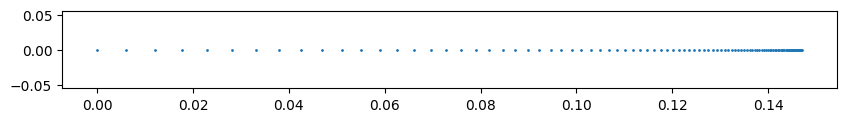

In [ ]:
ar_grid=1/7
az_grid = 60
z0test=0.10
rtest, ztest=gridStatistics(ar_grid, az_grid,
                            generate_grid_ar,
                            generate_grid_geom,
                            Mtest=M,
                            Ntest=100,
                            z0test=z0test)

plt.figure(figsize=(10,1))
plt.scatter(ztest,np.arange(len(ztest))*0, s=1)
plt.show()

In [ ]:
# function for reading and preparing experimental data

def read_data(path, r, z):
    df = pd.read_csv(path, names = ['r', 'z', 'f'], sep='\s+')

    try:
        df.iloc[0, :].str.isalpha().sum()
        df = pd.read_csv(path)
        df.columns = ['r', 'z', 'f']
    except AttributeError:
        pass

    if df.z.isnull().any():
        df = pd.read_csv(path, names = ['r', 'z', 'f'],
                         skiprows=1)
    if df.z.max() > 10:
        df.z *= 1e-2
        df.r *= 1e-2
    print(f'zmin_exp={df.z.min()}, zmax_exp={df.z.max()}')
    print(f'rmin_exp={df.r.min()}, rmax_exp={df.r.max()}')
    dz = np.max(z) - df.z.max()
    df.z += dz
    f = griddata((df.r, df.z), df['f'], (r, z))



    for i in range(f.shape[1]):
        mask = ~np.isnan(f[:-5, i])
        Tinterp = np.interp(z[:-5, i][~mask],
                            z[:-5, i][mask],
                            f[:-5, i][mask])
        args=np.where(f[:-5, i][~mask])
        f[:, i][args] = Tinterp
    f[-1] = f[-2]
    nani = np.argwhere(np.isnan(f))
    for i in nani:
        if i[0]-1 > 0 and ~np.isnan(f[i[0]-1, i[1]]):
            f[i[0], i[1]] = f[i[0]-1, i[1]]
        else:
            mask = np.isnan(f)
            f[mask] = np.mean(f[~mask])
            #f[mask] = T0
    if 'T.txt' in path or '_temperature.csv' in path:
        if np.min(f) > 294:
            f -= (273.15 + 22)
        elif np.min(f) > 273:
            f -= 273.15
        else:
            f -= np.min(f)
    f[0]=f[1]

    return f

In [ ]:
class ExpData(Dataset):
    def __init__(
            self,
            pathfile = '200_11_9/',
            path_vz_axis_exp = '3_200grad_Vz_Vr/vz_axis/6_reg_vz_z.csv',
            path_vaz_rad = '8_hot_wire_anemometer/2024_12_04/vz_r=30mm_central.txt',
            pathexpfile = None,
            wc=0,
            M=50,
            N=50,
            Nt=10,
            Mt=10,
            r0_g=None, z0_g=None,
            az_grid = 2, ar_grid=2,
            z0=None, r0=None
            ):
        self.M = M
        self.N = N

        self.Nt = Nt
        self.Mt = Mt

        self.wc = wc
        self.z0 = z0
        self.r0 = r0

        if not r0_g:
          r0_g = d0
        if not z0_g:
          z0_g = zmax*0.9

        self.path_vaz_rad = path_vaz_rad
        self.pathexpfile = pathexpfile
        self.pathfile = pathfile

        simdataU = pd.read_csv(pathfile+'Vr.txt', \
                          sep='\s+', header=None, names=['r', 'z', 'f'])
        simdataW = pd.read_csv(pathfile+'Vz.txt', \
                          sep='\s+', header=None, names=['r', 'z', 'f'])
        try:
          simdataP = pd.read_csv(pathfile+'p.txt', \
                            sep='\s+', header=None, names=['r', 'z', 'f'])
        except:
          simdataP = pd.read_csv(pathfile+'P.txt', \
                  sep='\s+', header=None, names=['r', 'z', 'f'])
        simdataMut = pd.read_csv(pathfile+'muT.txt', \
                          sep='\s+', header=None, names=['r', 'z', 'f'])
        simdataT = pd.read_csv(pathfile+'T.txt', \
                    sep='\s+', header=None, names=['r', 'z', 'f'])

        self.rho0 = rho_def(T0 + 273.15)

        #r = np.linspace(rmin,  rmax, num=self.M)
        #z = np.linspace(zmin,  zmax, num=self.N)


        r = generate_grid_ar(rmin, rmax, ar_grid, self.M)
        z = generate_grid_geom(zmin, zmax, az_grid, self.N)

        rt = np.linspace(rmin,  rmax, num=self.Mt)
        zt = np.linspace(zmin,  zmax, num=self.Nt)
        self.rt, self.zt = np.meshgrid(rt, zt)

        r, z = np.meshgrid(r, z)

        self.r = r
        self.z = z

        self.vr = self.interpolatedata(simdataU)
        mask = (self.r <=  r_disk) & (self.z == np.max(self.z))
        self.vr[mask] = 0
        #self.vr[-1] = 0
        #r_disk
        self.vz = self.interpolatedata(simdataW)
        self.vz[mask] = 0
        #self.vz[-1] = 0
        self.a = self.vr / self.r
        vz_0 = np.array(np.diff(self.vz[:,0])/np.diff(self.z[:,0]))
        vz_0[-1] = vz_0[-2]
        vz_0 = np.append(vz_0, vz_0[-1])
        self.a[:,0] = -0.5*vz_0

        self.p = self.interpolatedata(simdataP)
        self.p[-1] = self.p[-2]
        self.mut = self.interpolatedata(simdataMut)
        self.mut[mask] = 0
        self.Tsim = self.interpolatedata(simdataT)


        self.Tsim[-1] = self.Tsim[-2]

        if pathexpfile:
            Texpraw = read_data(pathexpfile, self.r, self.z)
            self.T = Texpraw.reshape(self.N, self.M)
            self.T[-1] = self.T[-2]
            Texpraw_data = read_data(pathexpfile, self.rt, self.zt)
            self.TData = Texpraw_data.reshape(self.Nt, self.Mt)
            #self.TData[-1] = self.TData[-2]
        else:
            self.T = self.Tsim
            self.TData = self.interpolatedata(simdataT, r=self.rt,
                                     z=self.zt)
            self.TData[-1] = self.TData[-2]
        if wc:
            self.lambt = self.mut * eta_mol(self.T+Tref)*Cp/Pr_t/lambda_mol
        else:
            self.lambt = self.mut*Cp/Pr_t*mu_mol/lambda_mol

        if np.min(self.Tsim) >= (Tref-5):
          self.Tsim -= Tref
          self.Tsim[self.Tsim<0]=0
        if np.min(self.T) >= (Tref):
          self.T -= Tref
          self.T[self.T<0]=0
        if np.min(self.TData) >= (Tref-5):
          self.TData -= Tref
          self.TData[self.TData<0]=0

        if z0 is not None:
            self.rad_profile(z0)
        if r0 is not None:
            self.vert_profile(r0)

    def interpolatedata(self, data, r=None, z=None):
      if r is None:
        finterp = griddata((data.r, data.z), data.f, (self.r, self.z))
      else:
        finterp = griddata((data.r, data.z), data.f, (r, z))
      finterp[-1, :] = finterp[-2, :]

      return finterp

    def rad_profile_sim(self, z0=0.12, r0=0.06):
        r = np.linspace(rmin,  rmax, num=self.M)
        z = np.linspace(zmin,  zmax, num=self.N)
        r, z = np.meshgrid(r, z)
        simdataW = pd.read_csv(self.pathfile+'Vz.txt', \
                          sep='\s+', header=None, names=['r', 'z', 'f'])
        vz = self.interpolatedata(simdataW, r=r, z=z)

        j=np.argmin(np.abs(z[:,0]-z0))

        mask = r[0] > 0.025
        vz = np.hstack((vz[j][~mask][::2],
                      vz[j][mask][::5]))
        r = np.hstack((r[j][~mask][::2],
                      r[j][mask][::5]))

        self.vz_rad =  np.stack((r,
                                np.ones_like(r)*z[j,0],
                                 vz)).T

        r = np.linspace(rmin,  rmax, num=self.M)
        z = np.linspace(zmin,  zmax, num=self.N)
        r, z = np.meshgrid(r, z)
        simdataU = pd.read_csv(self.pathfile+'Vr.txt', \
                          sep='\s+', header=None, names=['r', 'z', 'f'])
        vr = self.interpolatedata(simdataU, r=r, z=z)

        j2=np.argmin(np.abs(r[0]-r0))
        print(f'j2={j2}')

        mask = z[:, 0] < 0.12
        vr = np.hstack((vr[:,j2][~mask][::2],
                      vr[:,j2][mask][::5]))
        z = np.hstack((z[:, 0][~mask][::2],
                      z[:, 0][mask][::5]))

        a=vr/r[0, j2]

        self.a_vert =  np.stack((np.ones_like(z)*r[0, j2],
                                z, a)).T

    def vert_profile(self, r0=0.05):
      vr_ke = np.loadtxt(self.pathfile+'Vr(z)_r=0_05m.txt')
      vr_ke = np.concatenate((np.ones_like(vr_ke[:, 0:1])*r0, vr_ke), axis=1)

      mask = vr_ke[:, 1] < 0.12
      st1, st2= 1, 20
      print(vr_ke.shape)
      vr_ke = np.vstack((vr_ke[~mask][::st1, :],
                      vr_ke[mask][::st2,:]))
      vr_ke[:, 2] /= vr_ke[:, 0]
      vr_ke[np.isnan(vr_ke)] = 0

      self.a_vert =  vr_ke

    def rad_profile(self, z0=0.025):
        vz = np.loadtxt(self.path_vaz_rad,
                        skiprows=1,
                        delimiter=',')
        step = 3
        dr = - 0.003
        T0 = 28

        vz[:, 0] = vz[:, 0] + dr
        vz = vz[vz[:, 0] <= 0]
        vz[:, 0] = vz[::-1, 0] - np.min(vz[:, 0])

        vz = vz[::step]
        vz_rad_exp =  np.stack((vz[:, 0],
                                 np.ones_like(vz[:, 0])*z0,
                                 vz[:, 1])).T
        simdataW = pd.read_csv(self.pathfile+'Vz.txt', \
                          sep='\s+', header=None, names=['r', 'z', 'f'])
        finterp = griddata((simdataW.r, simdataW.z), simdataW.f, vz_rad_exp[:, :2])
        self.vz_rad =  np.stack((vz[:, 0],
                                 np.ones_like(vz[:, 0])*z0,
                                 finterp)).T


    def normalization(self):
        def norm_vz_arr(arr):
            arr[:,0] /= l
            arr[:,1] = arr[:,1] / l / z_0
            arr[:,2] /= v0
            return arr

        self.r = self.r / l
        self.z = self.z / l / z_0
        self.rt = self.rt / l
        self.zt = self.zt / l / z_0

        if self.z0 is not None:
            self.vz_rad[:, 0] /= l
            self.vz_rad[:, 1] /= (l * z_0)
            self.vz_rad[:, 2] /= v0
        if self.r0 is not None:
            self.a_vert[:, 0] /= l
            self.a_vert[:, 1] /= (l * z_0)
            self.a_vert[:, 2] = self.a_vert[:, 2]/(v0/l)/a0

        self.vr = self.vr / v0 / vr_0
        self.vz = self.vz / v0
        self.T = self.T / Tnorm
        self.Tsim = self.Tsim / Tnorm
        self.TData = self.TData / Tnorm
        pres0 = rho_def(T0 + 273.15) * (v0**2) # CONST
        self.p = self.p / pres0 / p_0
        if self.wc:
            self.mut = self.mut * eta_mol(self.T*Tnorm+Tref) / mu_mol / mu0
        else:
            self.mut = self.mut / mu0
        self.lambt = self.lambt / lam0

        self.a = self.a/(v0/l)/a0


In [ ]:
simFields = ExpData(pathfile='5_KE_sim/33_HIJ_58BOS/',
                    path_vaz_rad='2_h_plate=14_7cm/v6/120_mm.csv',
                    wc=0, M=M, N=N,
                    Nt=90, Mt=90,
                    z0=0.12, r0=0.05,
                    az_grid = az_grid, ar_grid=1/7)

/tmp/ipython-input-20-57565075.py:77: RuntimeWarning: divide by zero encountered in divide
  self.a = self.vr / self.r
/tmp/ipython-input-20-57565075.py:77: RuntimeWarning: invalid value encountered in divide
  self.a = self.vr / self.r


(901, 3)


In [ ]:
simFields.T[np.isnan(simFields.T)] = 0
simFields.Tsim[np.isnan(simFields.Tsim)] = 0
simFields.vz[np.isnan(simFields.vz)] = 0
simFields.a[np.isnan(simFields.a)] = 0
simFields.vr[np.isnan(simFields.vr)] = 0
simFields.p[np.isnan(simFields.p)] = 0
#simFields.p_sum[np.isnan(simFields.p)] = 0
simFields.mut[np.isnan(simFields.mut)] = 0
simFields.lambt[np.isnan(simFields.lambt)] = 0

In [ ]:
print(np.min(simFields.T))
print(np.min(simFields.Tsim))
print(np.min(simFields.TData))

0.0
0.0
0.0


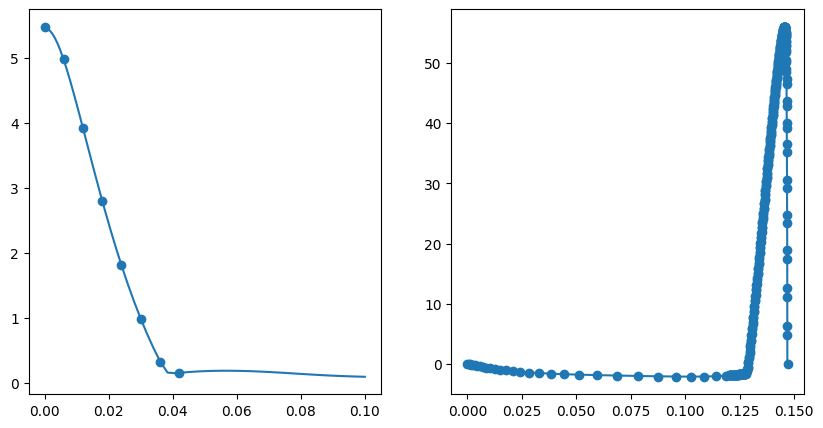

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

z0=0.12
r0=0.05

ia=0
i=np.argmin(np.abs(simFields.z[:,0]-z0))
ax[ia].scatter(simFields.vz_rad[:,0], simFields.vz_rad[:,2])
ax[ia].plot(simFields.r[i,:], simFields.vz[i,:])

ia+=1
j=np.argmin(np.abs(simFields.r[0,:]-r0))
ax[ia].scatter(simFields.a_vert[:,1], simFields.a_vert[:,2])
ax[ia].plot(simFields.z[:,0], simFields.a[:,j])
plt.show()

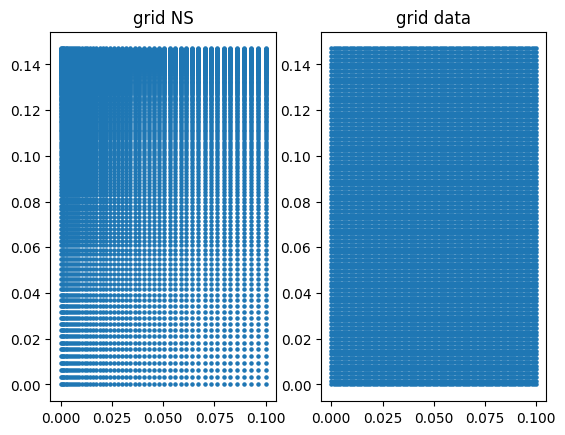

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(simFields.r, simFields.z, s=5)
ax[0].set_title('grid NS')
ax[1].scatter(simFields.rt, simFields.zt, s=5)
ax[1].set_title('grid data')

plt.show()

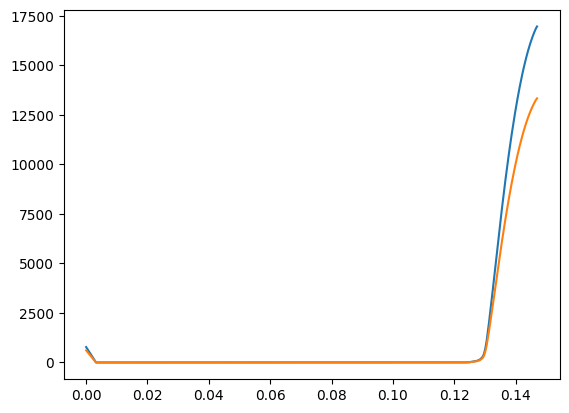

In [ ]:
plt.plot(simFields.z[:, -1], simFields.mut[:, -1]*mu0)
plt.plot(simFields.z[:, -1], simFields.lambt[:, -1]*mu0)

/tmp/ipython-input-27-4119249329.py:1: RuntimeWarning: invalid value encountered in divide
  Prsim = Cp_det(simFields.T*0+Tref)*(simFields.mut*mu0-1*0)*mu_mol/\


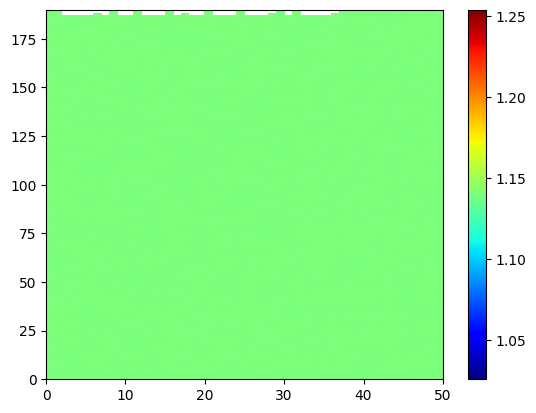

In [ ]:
Prsim = Cp_det(simFields.T*0+Tref)*(simFields.mut*mu0-1*0)*mu_mol/\
        ((simFields.lambt*lam0-1*0)*lambda_mol)
plt.pcolor(Prsim, cmap='jet')
plt.colorbar()

plt.show()

In [ ]:
#Normalization constants

def norm_values():
    print('Tnorm= ', np.max(simFields.TData))
    v0 = np.max(simFields.vz)
    print('V0= ', v0)
    print('a0= ', np.max(simFields.a) /(v0/l))

    pres0 = rho_def(T0 + 273.15) * (v0**2)
    print('p_0= ', np.max(simFields.p) / pres0)
    print('mu0= ', np.max(simFields.mut))
    print('lambda0= ', np.max(simFields.lambt))

norm_values()

Tnorm=  234.99999476143068
V0=  11.367227332836219
a0=  2.4806108005347447
p_0=  0.07801651109331535
mu0=  183.8588085150217
lambda0=  144.50140096573574


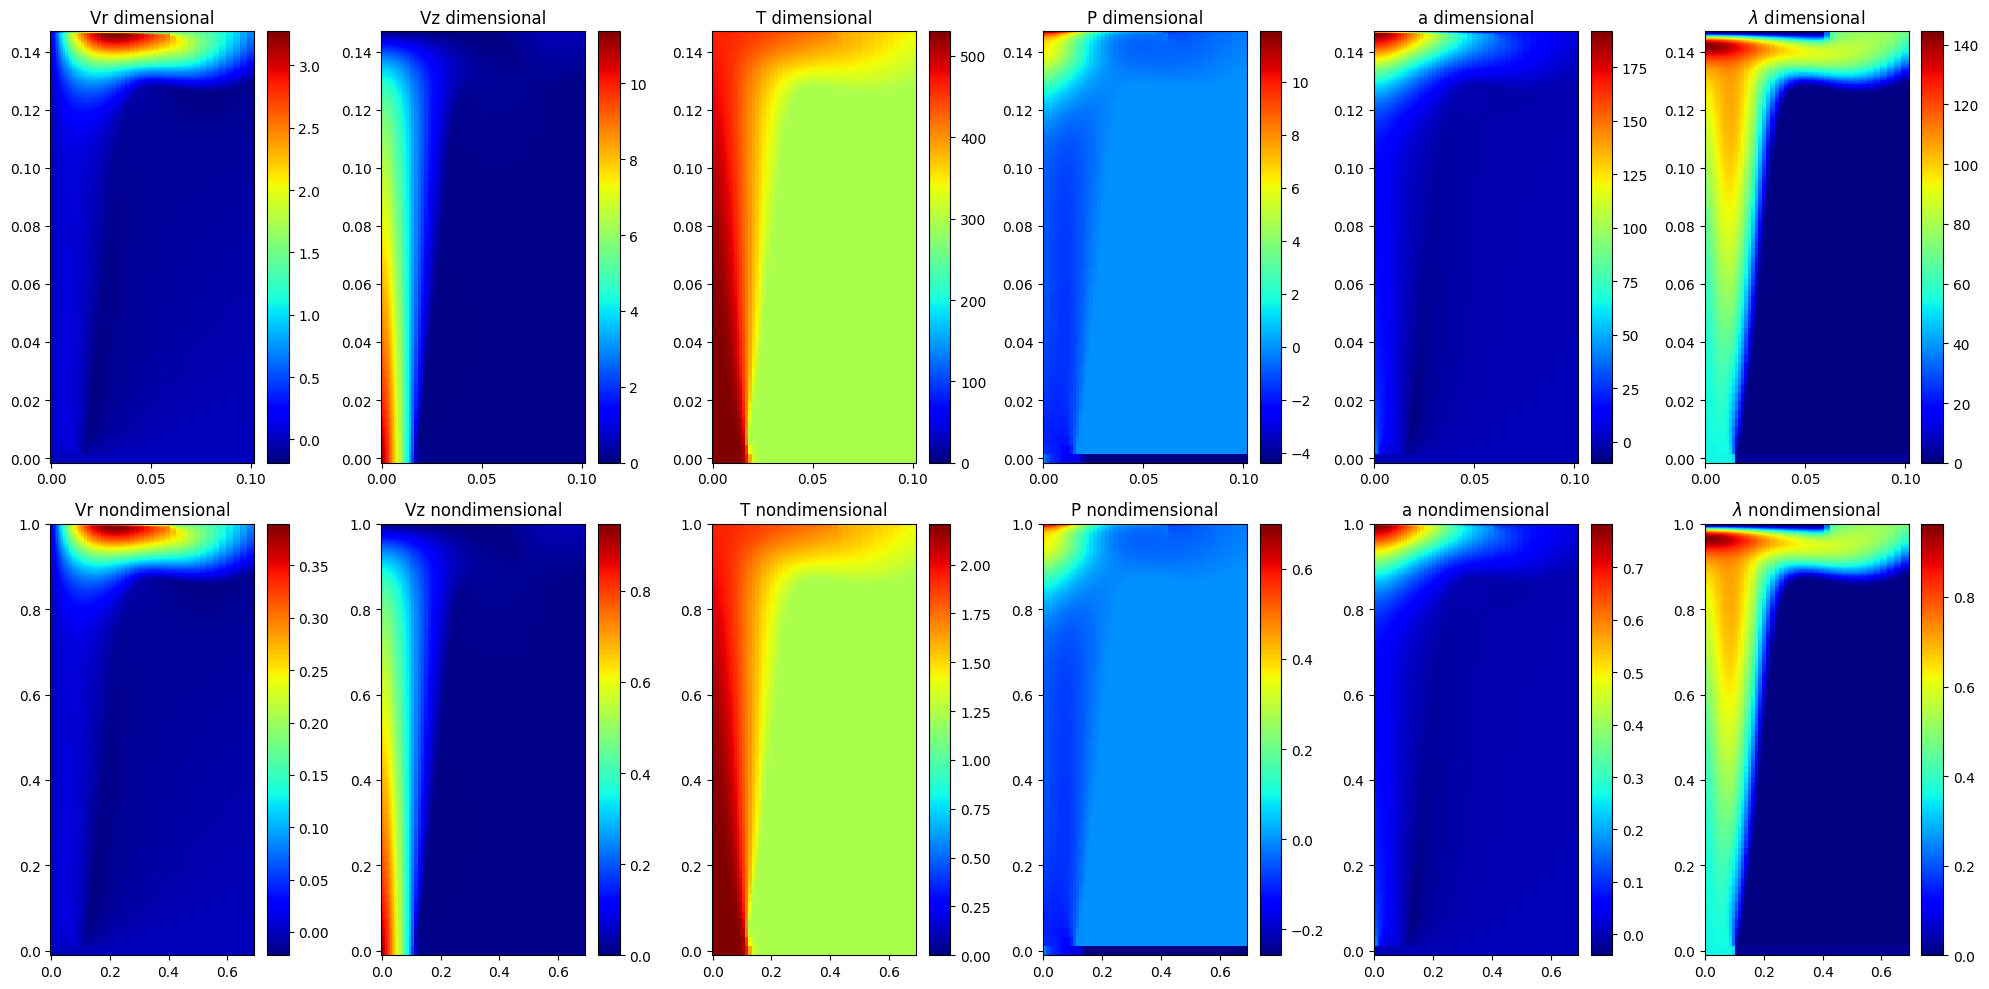

In [ ]:
# Check and normilize all data

fig, ax = plt.subplots(2, 6, figsize=(20, 10))
titles = ['Vr', 'Vz', 'T', 'P', 'a', r'$\lambda$']

for i, field in enumerate((simFields.vr, simFields.vz,
                           simFields.T, simFields.p, simFields.a,
                           simFields.lambt)):
    im = ax[0, i].pcolor(simFields.r, simFields.z, field, cmap='jet')
    ax[0, i].set_title(titles[i]+' dimensional')
    plt.colorbar(im, ax=ax[0, i])

#normalization
simFields.normalization()

for i, field in enumerate((simFields.vr, simFields.vz,
                           simFields.T, simFields.p, simFields.a,
                           simFields.lambt)):
    im = ax[1, i].pcolor(simFields.r, simFields.z, field, cmap='jet')
    ax[1, i].set_title(titles[i]+' nondimensional')
    plt.colorbar(im, ax=ax[1, i])

plt.tight_layout()
plt.show()

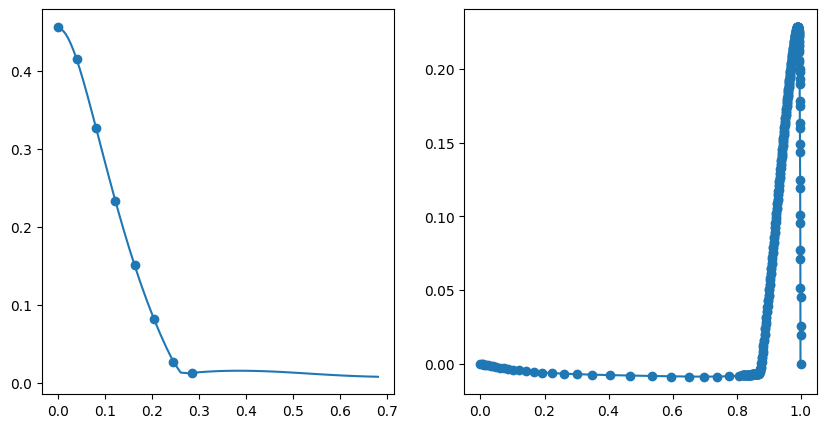

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

z0=0.12/l
r0=0.05/l

ia=0
i=np.argmin(np.abs(simFields.z[:,0]-z0))
ax[ia].scatter(simFields.vz_rad[:,0], simFields.vz_rad[:,2])
ax[ia].plot(simFields.r[i,:], simFields.vz[i,:])

ia+=1
j=np.argmin(np.abs(simFields.r[0,:]-r0))
ax[ia].scatter(simFields.a_vert[:,1], simFields.a_vert[:,2])
ax[ia].plot(simFields.z[:,0], simFields.a[:,j])
plt.show()

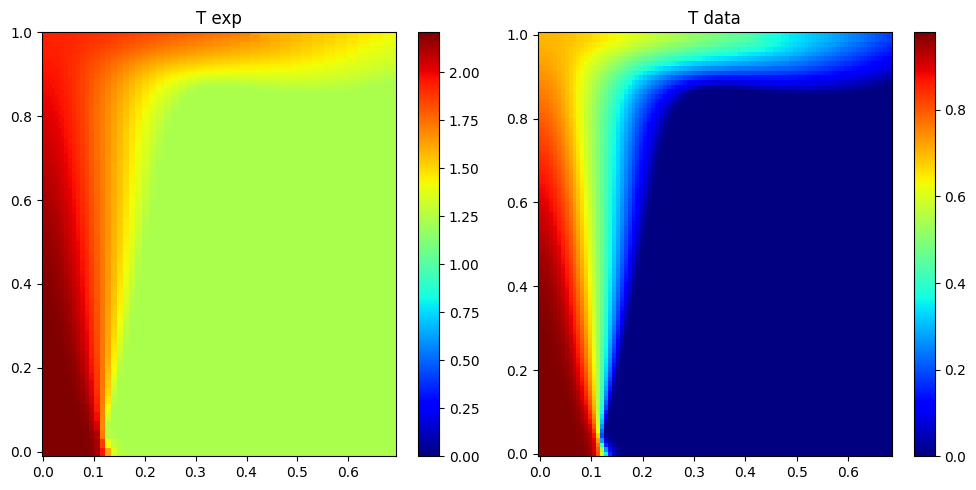

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im = ax[0].pcolor(simFields.r, simFields.z, simFields.T, cmap='jet')
ax[0].set_title('T exp')
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolor(simFields.rt, simFields.zt, simFields.TData, cmap='jet')
ax[1].set_title('T data')
plt.colorbar(im, ax=ax[1])

plt.tight_layout()

plt.show()

In [ ]:
print(f'Vr_max:{np.max(np.abs(simFields.vr))}')
print(f'Vz_max:{np.max(np.abs(simFields.vz))}')

print(f'T_max:{np.max(np.abs(simFields.TData))}')
print(f'p_max:{np.max(np.abs(simFields.p))}')
print(f'muT_max:{np.max(np.abs(simFields.mut))}')
print(f'lambT_max:{np.max(np.abs(simFields.lambt))}')
print(f'a_max:{np.max(np.abs(simFields.a))}')

Vr_max:0.38973767993810665
Vz_max:0.9472689444030182
T_max:0.9791666448392945
p_max:0.7000565504508344
muT_max:0.9676779395527458
lambT_max:0.963342673104905
a_max:0.7832685248324246


In [ ]:
print(f'Vr:{np.isnan(simFields.vr).sum()}')
print(f'Vz:{np.isnan(simFields.vz).sum()}')

print(f'T:{np.isnan(simFields.T).sum()}')
print(f'TData:{np.isnan(simFields.TData).sum()}')
print(f'p:{np.isnan(simFields.p).sum()}')
print(f'muT:{np.isnan(simFields.mut).sum()}')
print(f'lambT:{np.isnan(simFields.lambt).sum()}')
print(f'a:{np.isnan(simFields.a).sum()}')

if np.isnan(simFields.a).sum():
    simFields.a[np.isnan(simFields.a)] = 0

print(f'a:{np.isnan(simFields.a).sum()}')

Vr:0
Vz:0
T:0
TData:0
p:0
muT:0
lambT:0
a:0
a:0


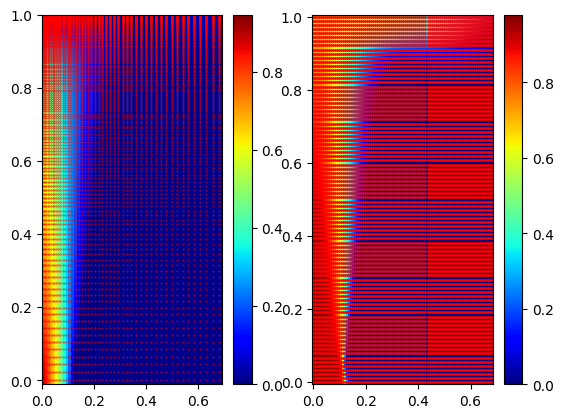

In [ ]:
fig, ax = plt.subplots(1, 2)

im1=ax[0].pcolor(simFields.r, simFields.z, simFields.vz, cmap='jet')
plt.colorbar(im1, ax=ax[0])
ax[0].scatter(simFields.r, simFields.z, s=0.1, c='r')
#ax[0].set_ylim(0.9, 0.97)

im1=ax[1].pcolor(simFields.rt, simFields.zt, simFields.TData, cmap='jet')
plt.colorbar(im1, ax=ax[1])
ax[1].scatter(simFields.rt, simFields.zt,s=1, c='r')

plt.show()

# Initial conditions, mask for equation residuals

In [ ]:
# To calculate metrics data must in tensors
Ttarget = torch.from_numpy(simFields.T).flatten().to(device)
TDatatarget = torch.from_numpy(simFields.TData).flatten().to(device)
Utarget = torch.from_numpy(simFields.vr).flatten().to(device)
Atarget = torch.from_numpy(simFields.a).flatten().to(device)
Vtarget = torch.from_numpy(simFields.vz).flatten().to(device)
Ptarget = torch.from_numpy(simFields.p).flatten().to(device)
Mutarget = torch.from_numpy(simFields.mut).flatten().to(device)
lambtarget = torch.from_numpy(simFields.lambt).flatten().to(device)
vzradtarget = torch.from_numpy(simFields.vz_rad[:, 2]).flatten().to(device)
averttarget = torch.from_numpy(simFields.a_vert[:, 2]).flatten().to(device)

#vzplatetarget = torch.from_numpy(simFields.vz_plate[:, 2]).flatten().to(device)
#aplattarget = torch.from_numpy(simFields.a_plate[:, 2]).flatten().to(device)

In [ ]:
vzradtarget.shape

torch.Size([8])

In [ ]:
Atarget[torch.isnan(Atarget)]=0

In [ ]:
print(torch.isnan(Ttarget).any())
print(torch.isnan(Utarget).any())
print(torch.isnan(Atarget).any())
print(torch.isnan(Vtarget).any())

print(torch.isnan(Ptarget).any())
print(torch.isnan(Mutarget).any())

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [ ]:
def pw_vz(r):
    T0 = 28
    Ujet = 6.5
    a = 10/13
    rjet = d0
    Tgrid = griddata(simFields.rt[0],
                     simFields.TData[0],
                    r)
    vz = Ujet * (1 - r*l/rjet) ** a
    vz *= (22+273.15+Tgrid*Tnorm)/(T0+273.15)
    vz[np.isnan(vz)] = 0.02 * Ujet
    vz = vz / v0
    return vz

/tmp/ipython-input-39-1954320654.py:9: RuntimeWarning: invalid value encountered in power
  vz = Ujet * (1 - r*l/rjet) ** a


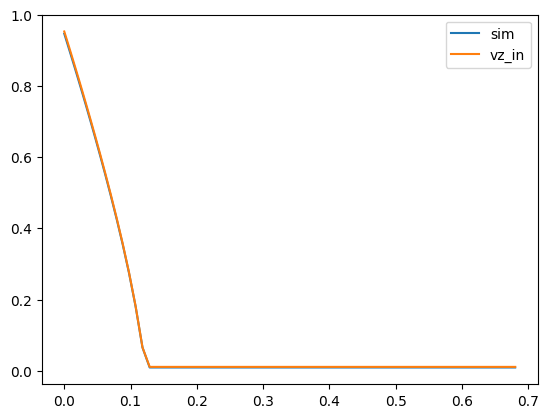

In [ ]:
vz_in = pw_vz(simFields.r[0,:])


plt.plot(simFields.r[0,:], simFields.vz[0,:], label='sim')
plt.plot(simFields.r[0,:], vz_in, label='vz_in')

plt.legend()
plt.show()

In [ ]:
def lam_tanh(r, l1=70, l2=3, r0=0.015, c=0.003):
    f = 0.5 * (l1 + l2 - (l1-l2)*np.tanh((r*l-r0)/c))
    f = f / lam0
    return f

In [ ]:
lamb_in = lam_tanh(simFields.r[0,:], l1=53, l2=3)

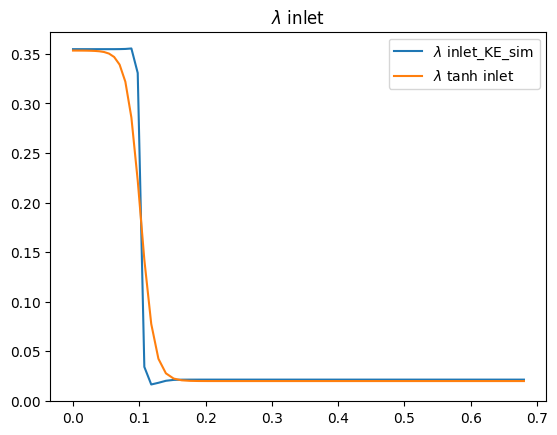

In [ ]:
plt.plot(simFields.r[0,:], simFields.lambt[0,:],
         label=r'$\lambda$ inlet_KE_sim')
plt.plot(simFields.r[0,:], lamb_in,
         label=r'$\lambda$ tanh inlet')
plt.legend()
plt.title(r'$\lambda$ inlet')
plt.show()

In [ ]:
def eta_tanh(r, m1=70, m2=3, r0=0.015, c=0.003):
    f = 0.5 * (m1 + m2 - (m1-m2)*np.tanh((r*l-r0)/c))
    f = f / mu0
    return f

In [ ]:
eta_in = eta_tanh(simFields.r[0,:], m1=68, m2=4)

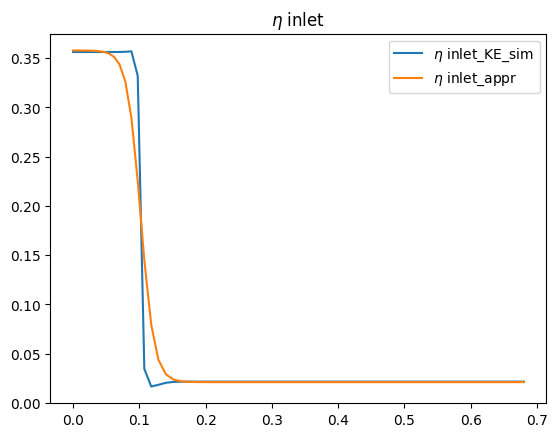

In [ ]:
plt.plot(simFields.r[0,:], simFields.mut[0,:],
         label=r'$\eta$ inlet_KE_sim')
plt.plot(simFields.r[0,:], eta_in,
         label=r'$\eta$ inlet_appr')
plt.legend()
plt.title(r'$\eta$ inlet')
plt.show()

In [ ]:
eta_in = torch.from_numpy(eta_in).to(device)
vz_in = torch.from_numpy(vz_in).to(device)
lamb_in = torch.from_numpy(lamb_in).to(device)

In [ ]:
maskRZT = torch.ones(N, M)
maskRZT[0,:] = 0
maskRZT[:,0] = 0
#maskRZT[:,-1] = 0
#maskRZT[-1, :] = 0
maskRZTvis = maskRZT
maskRZT = maskRZT.flatten().to(device)

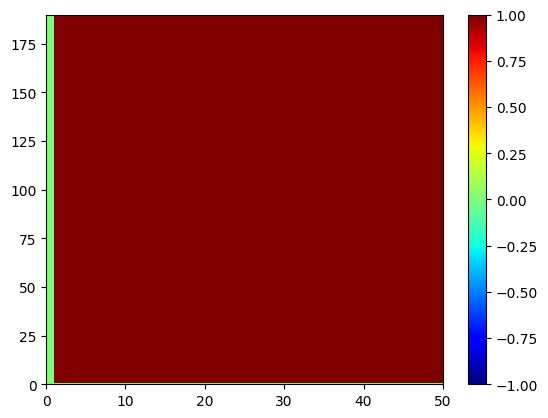

In [ ]:
plt.pcolor(maskRZTvis.detach().cpu(), cmap='jet', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

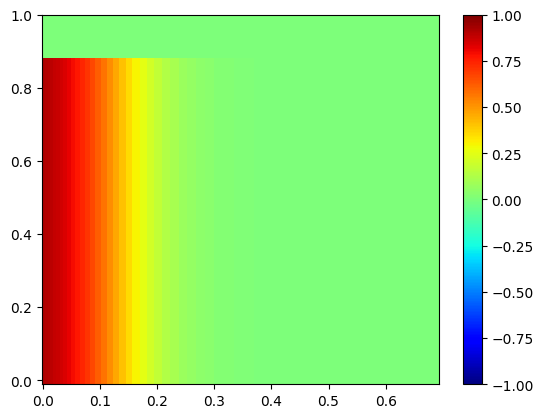

In [ ]:
def mask_inlet_closure(a1=1, a2=0, r0=0.018, c=0.0005):
  def mask_inlet(r):
    f = 0.5*((a1+a2)-(a1-a2)*np.tanh((r-r0)/c))
    return f
  return mask_inlet

f_Prt = mask_inlet_closure(a1=1, a2=0, r0=d0/l, c=0.1)

def mask_Prt(arr, f):
    result = np.apply_along_axis(f, axis=0, arr=arr)

    return result

mPrt = mask_Prt(simFields.r, f_Prt)
mPrt[simFields.z > 0.13/l]=0

plt.pcolor(simFields.r, simFields.z, mPrt, cmap='jet', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
mPrt = torch.from_numpy(mPrt.flatten()).to(device)

In [ ]:
class Metrics_ac():
    def __init__(self):

        self.NRMSE_mean = lambda x, y: \
                    torch.sqrt(torch.mean(torch.pow(x-y, 2)))/ \
                    torch.abs(torch.mean(y))
        self.NRMSE_max = lambda x, y: \
                    torch.sqrt(torch.mean(torch.pow(x-y, 2)))/ \
                    torch.abs(torch.max(y))

    def calculate(self, pred, target):
        mean_m= self.NRMSE_mean(pred.float(), target.float())
        max_m = self.NRMSE_max(pred.float(), target.float())
        return mean_m, max_m

# Model (PINN)

In [ ]:
from typing import OrderedDict

class PINN_2d(nn.Module):
    def __init__(self,
                input_size = 2,
                hidden_size = 30*6,
                output_size = 6,
                 ):
        super().__init__()

        self.layers_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #1
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #2
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #3
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #4
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #5
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #6
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), #6
            nn.Tanh(),
            nn.Linear(hidden_size, output_size), #7
        )
        self.act_tanh = nn.Tanh()
        self.act_sigm = nn.Sigmoid()

    def forward(self, x):
        y = self.layers_stack(x)
        y[:, :2] = self.act_tanh(y[:, :2]) #a, v
        y[:, 2] = self.act_sigm(y[:, 2]) #T
        y[:, 3] = self.act_tanh(y[:, 3]) #p
        y[:, 4:] = self.act_sigm(y[:, 4:]) #\lambda, \mu
        #y[:, 4:] = self.act_tanh(y[:, 4:]) #\lambda, \mu
        return y

In [ ]:
model = PINN_2d(hidden_size=20*6).to(device)

In [ ]:
n_iter=0

In [ ]:
run = neptune.init_run(
    project="ykrudenko/"+numExp+"exp",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmU4ODAwNS1kMGRjLTRjYmMtOWNmOS1iM2RmMWJjNTI5ZmQifQ==",
)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ykrudenko/453exp/e/EXP366-4


# Training

In [ ]:
eps = 1e-6
eps_w = 100
num_points=100

R, Z = torch.meshgrid(torch.from_numpy(simFields.r[0,:]),
                      torch.from_numpy(simFields.z[:,0]), indexing='xy')

Rt, Zt = torch.meshgrid(torch.from_numpy(simFields.rt[0,:]),
                      torch.from_numpy(simFields.zt[:,0]), indexing='xy')
coordsT = torch.stack([Rt.flatten(), Zt.flatten()], dim=1).to(device)
coordsT.requires_grad = True

width = simFields.r.max()
height = simFields.z.max()

coordinates = torch.stack([R.flatten(), Z.flatten()], dim=1).to(device)
coordinates.requires_grad = True  # Ensure coordinates require grad

rad_coords = torch.tensor(simFields.vz_rad[:, :2],
                     requires_grad=True).to(device)

vert_coords = torch.tensor(simFields.a_vert[:, :2],
                     requires_grad=True).to(device)

train_acc = Metrics_ac()


def navier_stokes_residuals(coords, inds):

    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    y_pred = model(coords.float())

    r = coords[:, 0]

    a, v, T, p, lamT, mu = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], \
                      y_pred[:, 3], y_pred[:, 4], y_pred[:, 5]

    TData = model(coordsT.float())[:, 2]

    acc_metrics = dict()

    mean_m, max_m = train_acc.calculate(a, Atarget[inds])

    acc_metrics['a_mean'], acc_metrics['a_max'] = mean_m, max_m
    mean_m, max_m = train_acc.calculate(v, Vtarget[inds])
    acc_metrics['VZ_mean'], acc_metrics['VZ_max'] = mean_m, max_m
    mean_m, max_m = train_acc.calculate(T, Ttarget[inds])
    acc_metrics['T_mean'], acc_metrics['T_max'] = mean_m, max_m
    mean_m, max_m = train_acc.calculate(TData, TDatatarget)
    acc_metrics['TData_mean'], acc_metrics['TData_max'] = mean_m, max_m
    mean_m, max_m = train_acc.calculate(p, Ptarget[inds])
    acc_metrics['p_mean'], acc_metrics['p_max'] = mean_m, max_m
    mean_m, max_m = train_acc.calculate(lamT, lambtarget[inds])
    acc_metrics['lambd_mean'], acc_metrics['lambd_max'] = mean_m, max_m
    mean_m, max_m = train_acc.calculate(mu, Mutarget[inds])
    acc_metrics['mu_mean'], acc_metrics['mu_max'] = mean_m, max_m

    def cont_eq(a, v, T):
      a = a * a0
      r = coords[:, 0]

      rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation
      rho_r = torch.autograd.grad(rho, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      a_r = torch.autograd.grad(a, coords, torch.ones_like(a), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      rho_z = torch.autograd.grad(rho, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0
      v_z = torch.autograd.grad(v, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0

      f1 = a*r*rho_r+rho*r*a_r+2*rho*a+v*rho_z+rho*v_z
      return f1

    def r_momentum_eq(a, v, T, p, mu):
      #eps = 1e-6
      r = coords[:, 0] + eps
      mu = mu*mu0
      a = a * a0
      p = p * p_0

      rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

      #derivatives
      a_r = torch.autograd.grad(a, coords, torch.ones_like(a), create_graph=True, \
                        retain_graph=True)[0][:, 0]
      a_z = torch.autograd.grad(a, coords, torch.ones_like(a), create_graph=True, \
                        retain_graph=True)[0][:, 1]/ z_0
      vz_r = torch.autograd.grad(v, coords, torch.ones_like(v), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      vz_z = torch.autograd.grad(v, coords, torch.ones_like(v), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0
      vr_r = r * a_r + a
      vr_z = r * a_z

      vz_r = torch.autograd.grad(v, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      vz_z = torch.autograd.grad(v, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0
      p_r = torch.autograd.grad(p, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]

      # div V = 1/r*d_dr(r*VR)+d_dz(VZ)
      div_v =  r*a_r+2*a+vz_z
      #div_v[(torch.isinf(div_v)) | (torch.isnan(div_v))] = 0

      # NS equation, r-projection
      # rho * (u * d_u/d_r + w * d_u/d_z)
      n1 = rho * (a*r*(r*a_r+a)+v*r*a_z)
      #-d_p/d_r
      n2 =  p_r
      # 1/Re0 * (d_(mu_*(-2/3 * div_v + 2*u_r))/d_r)


      n3 = 1/Re0 * torch.autograd.grad(mu*(-2/3*div_v + 2*vr_r),\
                          coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      # 1/Re0 * d_(mu * (u_z + w_r))/d_z
      n4 = 1/Re0 *torch.autograd.grad(mu*1*(vr_z + vz_r),\
                          coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0
      # 2/Re0 * mu/r * (u_r-u/r)
      n5 = 2/Re0 * mu / r * (vr_r - a)
      f2 = n1 - (-n2 + n3 + n4 + n5)
      return f2

    def z_momentum_eq(a, v, T, p, mu):
      eps = 1e-6
      r = coords[:, 0]
      mu = mu*mu0

      #mu = Pr_t/Cp*lamT*lam0*lambda_mol/mu_mol + 1
      a = a * a0
      p = p * p_0
      u = a * r

      #rho = torch.ones_like(T) # in equation
      rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

      #derivatives
      a_r = torch.autograd.grad(a, coords, torch.ones_like(a), create_graph=True, \
                        retain_graph=True)[0][:, 0]
      a_z = torch.autograd.grad(a, coords, torch.ones_like(a), create_graph=True, \
                        retain_graph=True)[0][:, 1]/ z_0
      vr_r = r * a_r + a
      vr_z = r * a_z
      vz_r = torch.autograd.grad(v, coords, torch.ones_like(rho), create_graph=True, \
                        retain_graph=True)[0][:, 0]
      vz_z = torch.autograd.grad(v, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0

      p_z = torch.autograd.grad(p, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0

      # div V = 1/r*d_dr(r*VR)+d_dz(VZ)
      div_v =  r*a_r+2*a+vz_z
      #div_v[(torch.isinf(div_v)) | (torch.isnan(div_v))] = 0

      # NS equation, z-projection
      # rho * (u * d_w/d_r + w * d_w/d_z)
      n1 = rho * (u * vz_r + v * vz_z)
      #-d_p/d_z
      n2 =  p_z
      # 1/Re0 * (d_(mu_*(-2/3 * div_v + 2*w_z))/d_z)
      n3 = 1/Re0 * 1*torch.autograd.grad(mu*(-2/3*div_v + 2*vz_z),\
                          coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0
      # 1/Re0 * d_(mu * (w_r + u_z))/d_r
      n4 = 1/Re0 * 1*torch.autograd.grad(mu*(vz_r + vr_z),\
                          coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      # 1/Re0 * mu / r * (u_z+w_r)
      n5 = 1/Re0 * mu * (a_z + vz_r /(eps+r))

      g=9.8
      F0 = (v0**2)/l
      n6=(rho-1)*g/F0

      f3 = n1 - (-n2 + n3 + n4 + n5 - n6)
      return f3

    def energy_eq(a, v, T, lamT):
      eps = 1e-6
      r = coords[:, 0]
      lamT = lamT * lam0
      a = a * a0
      u = a * r

      #rho = torch.ones_like(T) # in equation
      rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

      #derivatives
      T_r = torch.autograd.grad(T, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      T_z = torch.autograd.grad(T, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0

      #energy equation
      #rho*(u*d_T/d_r + w*d_T/d_z)
      n1 = rho * (u * T_r + v * T_z)
      #1/Pe0 * 1 / r * d_(lambda_*r*T_r)/dr
      n2 = 1/Pe0 * 1 / (eps+r)  * torch.autograd.grad(lamT*r*T_r, \
                              coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 0]
      #en_eq_mem2[0,0,:,0] = en_eq_mem2[0,0,:,0]*0
      #en_eq_mem2[(torch.isinf(en_eq_mem2)) | (torch.isnan(en_eq_mem2))] = 0
      #1/Pe0 * d_(lambda_*T_z)/dz
      n3 = 1/Pe0 *torch.autograd.grad(lamT*T_z, coords, torch.ones_like(rho), create_graph=True, \
                              retain_graph=True)[0][:, 1]/ z_0
      f4 = n1 - (n2 + n3)
      return f4

    def Prt_cond(mu, lam):
        f = 0.9*lambda_mol/Cp_det(Tref)/mu_mol*(lam*lam0-1)-(mu*mu0-1)
        return f

    def Prt_cond_free(mu, lam):
        f = 0.7*lambda_mol/Cp_det(Tref)/mu_mol*(lam*lam0)-(mu*mu0)
        return f

    continuity = cont_eq(a, v, T)
    r_momentum = r_momentum_eq(a, v, T, p, mu)
    z_momentum = z_momentum_eq(a, v, T, p, mu)
    energy = energy_eq(a, v, T, lamT)
    Prt_pred=Prt_cond(mu,lamT)

    dataTloss = torch.mean((Ttarget[inds] - T)**2)
    dataTDataloss = torch.mean((TDatatarget - TData)**2)
    dataAloss = torch.mean((Atarget[inds] - a)**2)
    dataVloss = torch.mean((Vtarget[inds] - v)**2)
    dataPloss = torch.mean((Ptarget[inds] - p)**2)
    dataLamloss = torch.mean((lamT - lambtarget[inds])**2)
    dataMuloss = torch.mean((mu - Mutarget[inds])**2)

    free_mask = ((coordinates[:, 0] == width) &\
                    (coordinates[:, 1] <= 0.1/l))

    axis_mask = (coordinates[:, 0] == 0)
    outlet_mask = ((coordinates[:, 1] == height) &\
                    (coordinates[:, 0] <= r_disk/l)) #radius of the disk
    outlet_mask_right = ((coordinates[:, 1] == height) &\
                    (coordinates[:, 0] > r_disk/l)) #radius of the disk
    inlet_mask = (coordinates[:, 1] == 0)
    inlet_mask_p = ((coordinates[:, 1] == 0) & (coordinates[:, 0] >= 2*d0/l))

    free_coords = coordinates[free_mask]

    inlet_coords = coordinates[inlet_mask]
    outlet_coords = coordinates[outlet_mask]
    outlet_coords_r = coordinates[outlet_mask_right]
    axis_coords = coordinates[axis_mask]
    inlet_p_coords = coordinates[inlet_mask_p]

    inlet_out = model(inlet_coords.float())
    inlet_p_out = model(inlet_p_coords.float())
    outlet_out = model(outlet_coords.float())
    outlet_out_r = model(outlet_coords_r.float())
    free_out = model(free_coords.float())
    axis_out = model(axis_coords.float())
    vz_rad_out = model(rad_coords.float())[:, 1]

    mu_free = free_out[:, 5]
    lam_free = free_out[:, 4]
    p_free = free_out[:, 3]
    Prt_free = Prt_cond_free(mu_free, lam_free)

    a_vert_out = model(vert_coords.float())[:, 0]

    vz_r_axis = torch.autograd.grad(axis_out[:,1],\
                          axis_coords, torch.ones_like(axis_out[:,0]), create_graph=True, \
                              retain_graph=True)[0][:, 0]
    vz_z_axis = torch.autograd.grad(axis_out[:,1],\
                        axis_coords, torch.ones_like(axis_out[:,0]), create_graph=True, \
                            retain_graph=True)[0][:, 1]
    p_r_axis = torch.autograd.grad(axis_out[:,3],\
                          axis_coords, torch.ones_like(axis_out[:,0]), create_graph=True, \
                              retain_graph=True)[0][:, 0]
    lam_r_axis = torch.autograd.grad(axis_out[:,4],\
                      axis_coords, torch.ones_like(axis_out[:,0]), create_graph=True, \
                          retain_graph=True)[0][:, 0]
    mu_r_axis = torch.autograd.grad(axis_out[:,5],\
                  axis_coords, torch.ones_like(axis_out[:,0]), create_graph=True, \
                      retain_graph=True)[0][:, 0]
    rho_axis = (T0 + 273.15) / (axis_out[:,2]*Tnorm + T0 + 273.15) # in equation

    rho_axis_z = torch.autograd.grad(rho_axis, axis_coords, \
                                     torch.ones_like(rho_axis), create_graph=True, \
                                     retain_graph=True)[0][:, 1]/ z_0


    axis_a_cond = 2*axis_out[:, 0]*rho_axis + rho_axis_z*axis_out[:, 1] + \
                  rho_axis*vz_z_axis

    outlet_da_dz_r = torch.autograd.grad(outlet_out_r[:, 0],\
                  outlet_coords_r, \
                  torch.ones_like(outlet_out_r[:,0]), create_graph=True, \
                  retain_graph=True)[0][:, 1]

    p_free_loss = torch.mean((p_free) ** 2)

    inlet_loss = torch.mean((inlet_out[:,0]) ** 2)+\
                 torch.mean((inlet_out[:,1]- vz_in)**2)+\
                 torch.mean((inlet_out[:,4] - lamb_in) ** 2) +\
                 torch.mean((inlet_out[:,5] - eta_in) ** 2)
                 #torch.mean((inlet_out[:,1] - vz_inlet_tanh_coflow) ** 2)+\
                 #torch.mean((inlet_out[:,1] - th_vz_max) ** 2)+\
                 #torch.mean((inlet_out[:,4] - lambtarget[inlet_mask]) ** 2) +\
                 #torch.mean((inlet_out[:,5] - Mutarget[inlet_mask]) ** 2)
                 #torch.mean((inlet_out[:,4] - lambd_in) ** 2) +\
                 #torch.mean((inlet_out[:,1]-Vtarget[inlet_mask])**2)

    red_vz_loss = torch.mean((vz_rad_out - vzradtarget) ** 2)
    vert_a_loss = torch.mean((a_vert_out - averttarget) ** 2)

    #plate_loss = torch.mean((a_plate_out - aplattarget) ** 2) # +\
                 #torch.mean((vz_plate_out - vzplatetarget) ** 2)
#vz_rad_out
    inlet_p_loss = torch.mean((inlet_p_out[:,3]) ** 2)
                   #torch.mean((inlet_p_out[:,4]-3/lam0) ** 2)+\
                   #torch.mean((inlet_p_out[:,5]-3/mu0) ** 2)

    #axis_loss = torch.mean(axis_a_cond**2+vz_r_axis**2+0.1*lam_r_axis**2+\
    #                       mu_r_axis**2)

    axis_loss = torch.mean(vz_r_axis**2+0.1*lam_r_axis**2+\
                           mu_r_axis**2)

    #outlet_loss = torch.mean(p_z_out**2)
    a_outlet_loss = torch.mean((outlet_out[:, 0]) ** 2)
    vz_outlet_loss =torch.mean((outlet_out[:, 1]) ** 2)
    eta_outlet_loss = torch.mean((outlet_out[:, 5]) ** 2)
    lamb_outlet_loss = torch.mean((outlet_out[:, 4]) ** 2)

    k_a_out, k_vz_out = 100, 100#100, 100
    k_eta_lamb_out = 0.1 #0.1

    outlet_loss =  k_a_out*a_outlet_loss +\
                   k_vz_out*vz_outlet_loss +\
                   k_eta_lamb_out*(lamb_outlet_loss +\
                   eta_outlet_loss)

    outlet_loss_r = torch.mean(outlet_da_dz_r ** 2)

    continuity =continuity*maskRZT[inds]
    r_momentum = r_momentum*maskRZT[inds]
    z_momentum = z_momentum*maskRZT[inds]
    energy = energy*maskRZT[inds]
    #Prt_pred = Prt_pred*mPrt
    #w_Pr = max(0, -(100/600)*iter_num + 100)
    w_Pr = 1

    L_Pr = torch.mean(Prt_pred**2)*w_Pr
    L_Prt_free = torch.mean(Prt_free**2)

    L_cont = torch.mean(continuity**2)
    L_r = torch.mean(r_momentum**2)
    L_z = torch.mean(z_momentum**2)
    L_energy = torch.mean(energy**2)


    L_pde = L_cont + L_r + L_z + L_energy
    #L_bc = inlet_loss + free_loss + axis_loss
    L_bc = axis_loss + inlet_loss + outlet_loss + inlet_p_loss + outlet_loss_r

    L_data = dataTDataloss #+ red_vz_loss

    #k_data_T = 50
    #k_vz = 10

    #total_loss =  (L_cont.pow(2) + L_r.pow(2) + L_z.pow(2) + L_energy.pow(2) + \
    #              inlet_loss.pow(2) + outlet_loss.pow(2) + axis_loss.pow(2) + \
    #              inlet_p_loss.pow(2) +\
    #              outlet_loss_r.pow(2) +\
    #              k_data_T*dataTDataloss.pow(2) +\
    #              k_vz*red_vz_loss.pow(2)) / \
    #              (L_pde+L_bc+L_data)

    #k_data_T = 1000
    #k_vz = 1
    #k_Pr = 100
    #k_bc=10
    #ke=1

    k_vz=100 #10
    k_data_T=100 #500
    k_Pr=100 #10
    k_bc=1 #100
    ke=1

    total_loss = k_data_T * dataTDataloss +\
                 k_vz*(vert_a_loss+red_vz_loss) +\
                 L_cont + L_r + L_z + L_energy +\
                 k_Pr*(L_Pr + L_Prt_free) +\
                 k_bc*(axis_loss +inlet_loss)+ 1*outlet_loss + 1*inlet_p_loss
    #k_vz*red_vz_loss +\
                 #outlet_loss_r) #+\
                 #k_a_out*a_outlet_loss

    metrics = {
        'n_iter': n_iter,
        'Prt_free_loss': Prt_free.detach(),
        'wr': w_Pr,
        'L_Pr_loss': L_Pr.detach(),
        'continuity': L_cont.detach(),
        'r_momentum_': L_r.detach(),
        'z_momentum_': L_z.detach(),
        'energy': ke*L_energy.detach(),
        'dataTloss': dataTloss.detach(),
        'dataTDataloss': k_data_T*dataTDataloss.detach(),
        'dataAloss': dataAloss.detach(),
        'dataVloss': dataVloss.detach(),
        'dataPloss': dataPloss.detach(),
        'dataMuloss': dataMuloss.detach(),
        'dataLamloss': dataLamloss.detach(),
        'inlet_loss': k_bc*inlet_loss.detach(),
        'rad_vz_loss': k_vz*red_vz_loss.detach(),
        'vert_a_loss': k_vz*vert_a_loss.detach(),
        'outlet_da/dz_r': k_bc*outlet_loss_r.detach(),
        'k*a_outlet_loss': k_a_out*a_outlet_loss.detach(),
        'k*vz_outlet_loss': k_vz_out*vz_outlet_loss.detach(),
        'axis_loss': k_bc*axis_loss.detach(),
        'p_free_loss':p_free_loss.detach(),
        'inlet_p_loss': k_bc*inlet_p_loss.detach(),
        'total_loss': total_loss.detach(),
        'outlet_loss': k_bc*outlet_loss.detach(),
        'a_outlet_loss':  k_a_out*a_outlet_loss.detach(),
        'vz_outlet_loss': vz_outlet_loss.detach(),
        'eta_outlet_loss': k_eta_lamb_out*eta_outlet_loss.detach(),
        'lamb_outlet_loss': k_eta_lamb_out*lamb_outlet_loss.detach()
    }

    for k, v in metrics.items():
      run[k].append(v)
    for k, v in acc_metrics.items():
      run[k].append(v)


    return total_loss

writer = SummaryWriter()

## training loop

In [ ]:
optimizer=torch.optim.LBFGS(model.parameters(),
                            lr=0.1,
                            max_iter=30)
                            #line_search_fn= 'strong_wolfe')
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
print(numExp)

453


In [ ]:
ref = y.get_meta("/NN_project/2_PINN/"+numExp+"exp").public_url
print(ref)

if ref:
  loadData(ref)
  print('ref exists')
else:
    ref='https://disk.360.yandex.ru/d/W3a3H_ciM_OaKQ'
    loadData(ref)

https://yadi.sk/d/pbonGeqhofY0FA
ref exists


In [ ]:
ls_folders = os.listdir(numExp+"exp/")
print(ls_folders)
if "checkpoints" in ls_folders:
    if glob.glob(numExp+"exp/checkpoints"+"/*.pth"):
        path_ck = numExp+"exp/checkpoints/checkpoint"+numExp+".pth"
        ck=torch.load(path_ck)
        print(ck.keys())
        model.load_state_dict(ck['model_state_dict'])
        optimizer.load_state_dict(ck['optimizer_state_dict'])
        print('weights have loaded')

['checkpoints', '453exp.ipynb']
dict_keys(['model_state_dict', 'optimizer_state_dict'])
weights have loaded


In [ ]:
folder_path = "/NN_project/2_PINN/"+numExp+"exp/checkpoints"
if not y.exists(folder_path):
    y.mkdir(folder_path)

In [ ]:
Niter_max = 100
Mwindow = 100

avg_iter_loss = np.array([0.0] * Niter_max)
window_loss = np.array([0.0] * Mwindow)

In [ ]:
lim_num_crit = 30000
lim_crit_loss = 0.0001
num_for_crit = 10000
deltaLoss = 1e4

def train():
    global n_iter;

    steps = 10000000
    pbar = tqdm(range(steps), desc='Training Progress')
    last_step_loss = None
    inds=list(range(len(coordinates)))


    for step in pbar:
        n_iter += 1

        def closure():
            optimizer.zero_grad()
            loss  = navier_stokes_residuals(coordinates, inds)
            loss.backward()
            return loss
        optimizer.step(closure)

        current_loss = closure().item()
        if last_step_loss:
            if current_loss-last_step_loss > deltaLoss:
                print('___DeltaLoss > 1e4___')
                return 0
        else:
            last_step_loss = current_loss

        window_loss[:Mwindow-1] = window_loss[1:Mwindow]
        window_loss[-1] = current_loss

        avg_iter_loss[:Mwindow-1] = avg_iter_loss[1:Mwindow]
        avg_iter_loss[-1] = np.mean(window_loss)


        if step % 2 == 0:
            pbar.set_description("Step: %d | Loss: %.6f | avg_loss: %.6f" %
                                 (step, current_loss, avg_iter_loss[-1]))

        if step % 10 == 0:
          checkpoint = {
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
          }

          ck_name = "checkpoint"+numExp+".pth"

          torch.save(checkpoint, ck_name)
          local_file = ck_name

          remote_path = folder_path + "/" + ck_name

          y.upload(local_file, remote_path, overwrite=True)

        last_step_loss = current_loss

        if step >= num_for_crit:
            delta = (np.max(avg_iter_loss) - np.min(avg_iter_loss))/\
                np.max(avg_iter_loss)
            pbar.set_description("Step: %d | Loss: %.6f | delta: %.6f" %
                            (step, current_loss, delta))
            if delta <= 0.005:
              torch.save(checkpoint, ck_name)
              local_file = ck_name
              remote_path = folder_path + "/" + ck_name
              y.upload(local_file, remote_path, overwrite=True)
              print('--------------END--------------')
              return 0

train()

writer.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s][neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs-legacy.neptune.ai/help/value_of_unsupported_type
Step: 840 | Loss: 0.007064 | avg_loss: 0.007166:   0%|          | 841/10000000 [2:16:53<29189:19:37, 10.51s/it]

# Save weights

In [ ]:
checkpoint = {
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
          }

torch.save(checkpoint, 'checkpoint'+numExp+'.pth')

# Predictions on a uniform grid

In [ ]:
Nu, Mu=500,500

if 1:
  simFieldsForPred = ExpData(pathfile='5_KE_sim/33_HIJ_58BOS/',
                    #pathexpfile = '58/T_BOS_exp_2025_01_16_58.csv',
                    path_vaz_rad='2_h_plate=14_7cm/v6/120_mm.csv',
                    wc=0, M=Mu, N=Nu,
                    Nt=90, Mt=90,
                    z0=0.12, r0=None,
                    az_grid = 1, ar_grid=1/1)
  simFieldsForPred.normalization()

/tmp/ipykernel_10877/57565075.py:77: RuntimeWarning: divide by zero encountered in divide
  self.a = self.vr / self.r
/tmp/ipykernel_10877/57565075.py:77: RuntimeWarning: invalid value encountered in divide
  self.a = self.vr / self.r


In [ ]:
r_uniform = torch.linspace(0, rmax/l, Nu)
z_uniform = torch.linspace(0, zmax/l/z_0, Mu)
r_u, z_u = torch.meshgrid(r_uniform, z_uniform)

u_grid = torch.vstack([r_u.flatten(), z_u.flatten()]).T
u_grid.requires_grad = True
u_grid = u_grid.to(device)
out = model(u_grid).to(device)

a = out[:, 0].detach().cpu().numpy().reshape(Nu, Mu).T
vz = out[:, 1].detach().cpu().numpy().reshape(Nu, Mu).T
T = out[:, 2].detach().cpu().numpy().reshape(Nu, Mu).T
lambt = out[:, 4].detach().cpu().numpy().reshape(Nu, Mu).T
mu = out[:, 5].detach().cpu().numpy().reshape(Nu, Mu).T
p = out[:, 3].detach().cpu().numpy().reshape(Nu, Mu).T

rout = u_grid[:,0].detach().cpu().numpy().reshape(Nu, Mu).T
zout = u_grid[:,1].detach().cpu().numpy().reshape(Nu, Mu).T

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


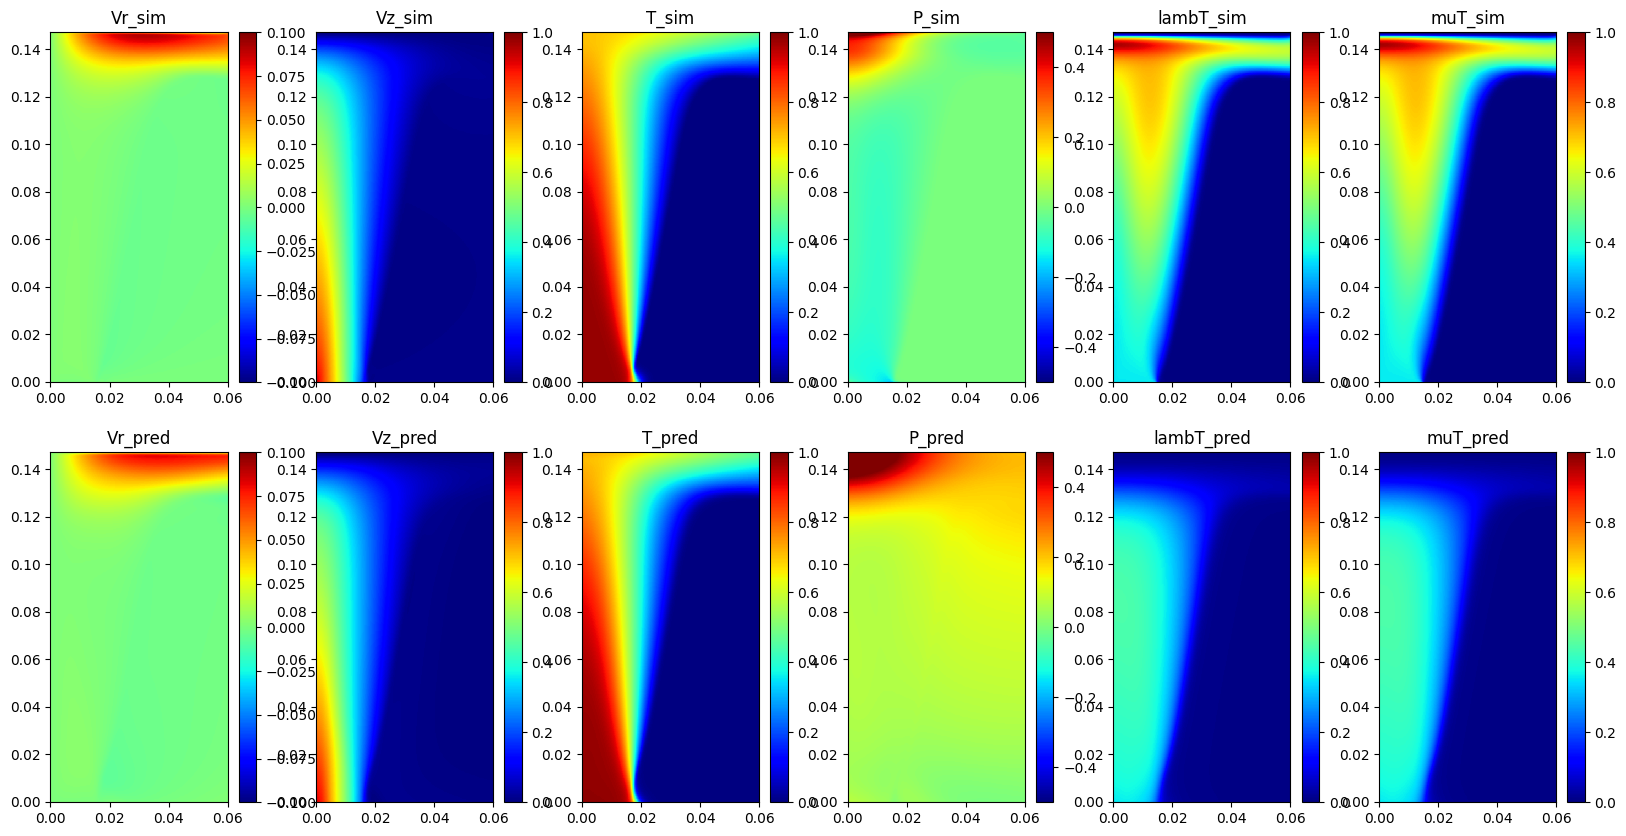

In [ ]:
im = [simFieldsForPred.a, simFieldsForPred.vz,
      simFieldsForPred.T, simFieldsForPred.p,
      simFieldsForPred.lambt, simFieldsForPred.mut]
out = [a, vz, T, p, lambt, mu]

titles = ['Vr', 'Vz', 'T', 'P', 'lambT', 'muT']
ca_sim = [(-0.1,0.1), (0, 1), (0, 1), (-0.5, 0.5),
          (0, 1), (0, 1)]
ca_pred = [
    (-0.1,0.1), (0, 1), (0, 1), (-0.5, 0.5),
          (0, 1), (0, 1)]

fig, ax = plt.subplots(2, 6, figsize=(20, 10))

for i in range(6):
  if i == 0:
    im_tar = ax[0, i].pcolor(simFieldsForPred.r*l, simFieldsForPred.z*l,
                            simFieldsForPred.r*im[i],
                             cmap='jet', vmin=ca_sim[i][0], vmax=ca_sim[i][1])
  else:
    im_tar = ax[0, i].pcolor(simFieldsForPred.r*l, simFieldsForPred.z*l,
                            im[i], cmap='jet', vmin=ca_sim[i][0], vmax=ca_sim[i][1])
  plt.colorbar(im_tar, ax=ax[0, i])
  ax[0, i].set_title(titles[i]+'_sim')
  ax[0, i].set_xlim(0, 0.06)

  if i == 0:
    im_pred = ax[1, i].pcolor(rout*l, zout*l,out[i]*rout, cmap='jet', vmin=ca_pred[i][0], vmax=ca_pred[i][1])
  else:
    im_pred = ax[1, i].pcolor(rout*l, zout*l,out[i], cmap='jet', vmin=ca_pred[i][0], vmax=ca_pred[i][1])
  plt.colorbar(im_pred, ax=ax[1, i])
  ax[1, i].set_title(titles[i]+'_pred')
  ax[1, i].set_xlim(0, 0.06)
  #ax[1, i].set_ylim(0.14, 0.147)
  #ax[0, i].set_ylim(0.14, 0.147)
plt.savefig('exp'+numExp+'.png')
plt.show()

In [ ]:
im = [simFieldsForPred.a*simFieldsForPred.r, simFieldsForPred.vz,
      simFieldsForPred.T, simFieldsForPred.p,
      simFieldsForPred.lambt, simFieldsForPred.mut]
out = [rout*a, vz, T, p, lambt, mu]

z0t1=0.147
z0t=z0t1/l
iz0t=np.argmin(np.abs(simFieldsForPred.z[:, 0]-z0t))

fig, ax = plt.subplots(2, 3)

for i in range(6):
  ax[i//3, i%3].plot(im[i][iz0t], label='sim')
  ax[i//3, i%3].plot(out[i][iz0t], label='PINN')
  ax[i//3, i%3].set_title(titles[i])
fig.suptitle(f'z0={z0t1}')
plt.tight_layout()
plt.legend()
plt.savefig('RADexp297_1.png')
plt.show()

In [ ]:
r0t1=0.01
r0t=r0t1/l
jr0t=np.argmin(np.abs(simFieldsForPred.r[0]-r0t))

fig, ax = plt.subplots(2, 3)

for i in range(6):
  ax[i//3, i%3].scatter(simFieldsForPred.z[:,0]*l,
                        im[i][:,jr0t],
                        s=2,
                        label='sim')
  ax[i//3, i%3].scatter(zout[:, 0]*l,
                        out[i][:,jr0t],
                        s=2,
                        label='PINN')
  ax[i//3, i%3].set_title(titles[i])
  ax[i//3, i%3].set_xlim(0.12, 0.147)
fig.suptitle(f'r0={r0t1}')
plt.tight_layout()
plt.legend()
plt.savefig('Vertexp297_1.png')
plt.show()

In [ ]:
Prt=Cp_det(T*Tnorm+Tref) * ((mu*mu0-1)*mu_mol) / ((lambt*lam0-1)*lambda_mol)

In [ ]:
plt.pcolor(simFieldsForPred.r*l, simFieldsForPred.z*l*z_0,
           Prt, cmap='jet',
           vmin=0.1, vmax=1.2)
plt.colorbar()
plt.gca().set_aspect('equal')
#plt.gca().set_xlim(0, 0.06)
plt.savefig('Prt_2D_334exp.png')
plt.show()

In [ ]:
h=[0.02, 0.05, 0.08, 0.1, 0.13]
ztest=simFieldsForPred.z*l*z_0
for z0 in h:
    i=np.argmin(np.abs(ztest[:,0]-z0))
    plt.plot(simFieldsForPred.r[0]*l,Prt[i], label=f'z0={z0}')
plt.axvline(x=d0, c='r', ls='--')
plt.legend()
plt.grid()
#plt.xlim(0, 0.045)
plt.ylim(0, 1)
plt.savefig('Prt_hor_334_exp.png')
plt.show()

In [ ]:
h=[0.02, 0.05, 0.08, 0.1, 0.13]
ztest=simFieldsForPred.z*l*z_0
for z0 in h:
    i=np.argmin(np.abs(ztest[:,0]-z0))
    plt.plot(Prt[i], label=f'z0={z0}')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.savefig('Prt_hor_332_exp.png')
plt.show()

In [ ]:
h=[0.08, 0.1, 0.15]
ztest=simFieldsForPred.z*l*z_0
for z0 in h:
    i=np.argmin(np.abs(ztest[:,0]-z0))
    plt.plot(l*simFieldsForPred.r[0], ((mu[i]*mu0)), label=f'z0={z0}')
plt.legend()
plt.savefig('mu_hor_143_exp.png')
plt.ylim(0,1)
plt.show()

# Estimation of equation residuals

In [ ]:
out = model(u_grid).to(device)

In [ ]:
def cont_eq_test(a, v, T, p, lamT):
    lamT = lamT * lam0
    a = a * a0
    p = p * p_0
    r = u_grid[:, 0]

    rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation
    rho_r = torch.autograd.grad(rho, u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 0]
    a_r = torch.autograd.grad(a, u_grid, torch.ones_like(a), create_graph=True, \
                            retain_graph=True)[0][:, 0]
    rho_z = torch.autograd.grad(rho, u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 1]/z_0
    v_z = torch.autograd.grad(v, u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 1]/z_0

    f1 = a*r*rho_r+rho*r*a_r+2*rho*a+v*rho_z+rho*v_z

    n1 = a*r*rho_r
    n2 = rho*r*a_r
    n3 = 2*rho*a
    n4 = v*rho_z
    n5 = rho*v_z

    return n1, n2, n3, n4, n5, f1

n1, n2, n3, n4, n5, f1 = cont_eq_test(out[:, 0], out[:, 1],out[:, 2],out[:, 3],out[:, 4])

In [ ]:
torch.mean(f1**2)

In [ ]:
nf = [n1,n2,n3,n4,n5]
nr = []
for n in nf:
  nr.append(n.detach().cpu().numpy().reshape(Nu, Mu).T)

nr.append(nr[4] +nr[0] + nr[1] + nr[2] + nr[3])

In [ ]:
titles = ['a*r*rho_r', 'rho*r*a_r', '2*rho*a', 'v*rho_z', 'rho*v_z', 'sum']
#ca_sim = [(-0.1, 0.1), (-0.1, 0.1),
#          (-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1)]
ca_sim = [(-0.01,0.01)]*6

fig, ax = plt.subplots(1, 6, figsize=(18, 12))

for i in range(6):
  im_tar = ax[i].pcolor(simFieldsForPred.r,
                        simFieldsForPred.z,
                        nr[i], cmap='jet', vmin=ca_sim[i][0], vmax=ca_sim[i][1])
  plt.colorbar(im_tar, ax=ax[i])
  ax[i].set_title(titles[i]+'_pred')

plt.show()

In [ ]:
def r_momentum_eq(a, v, T, p, lamT):
    eps = 1e-7
    r = u_grid[:, 0] + eps

    mu = Pr_t/Cp*lamT*lam0*lambda_mol/mu_mol + 1
    a = a * a0
    p = p * p_0

    rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

    #derivatives
    a_r = torch.autograd.grad(a, u_grid, torch.ones_like(a), create_graph=True, \
                      retain_graph=True)[0][:, 0]
    a_z = torch.autograd.grad(a, u_grid, torch.ones_like(a), create_graph=True, \
                      retain_graph=True)[0][:, 1]/ z_0
    vz_r = torch.autograd.grad(v, u_grid, torch.ones_like(v), create_graph=True, \
                            retain_graph=True)[0][:, 0]
    vz_z = torch.autograd.grad(v, u_grid, torch.ones_like(v), create_graph=True, \
                            retain_graph=True)[0][:, 1]/ z_0
    vr_r = r * a_r + a
    vr_z = r * a_z

    vz_r = torch.autograd.grad(v, u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 0]
    vz_z = torch.autograd.grad(v, u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 1]/ z_0
    p_r = torch.autograd.grad(p, u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 0]

    # div V = 1/r*d_dr(r*VR)+d_dz(VZ)
    div_v =  r*a_r+2*a+vz_z
    #div_v[(torch.isinf(div_v)) | (torch.isnan(div_v))] = 0

    # NS equation, r-projection
    # rho * (u * d_u/d_r + w * d_u/d_z)
    n1 = rho * (a*r*(r*a_r+a)+v*r*a_z)
    #-d_p/d_r
    n2 =  -p_r
    # 1/Re0 * (d_(mu_*(-2/3 * div_v + 2*u_r))/d_r)


    n3 = 1/Re0 * torch.autograd.grad(mu*(-2/3*div_v + 2*vr_r),\
                        u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 0]
    # 1/Re0 * d_(mu * (u_z + w_r))/d_z
    n4 = 1/Re0 *torch.autograd.grad(mu*1*(vr_z + vz_r),\
                        u_grid, torch.ones_like(rho), create_graph=True, \
                            retain_graph=True)[0][:, 1]/ z_0
    # 2/Re0 * mu/r * (u_r-u/r)
    n5 = 2/Re0 * mu / r * (vr_r - a)

    f2 = n1 - (n2 + n3 + n4 + n5)
    return f2

In [ ]:
f2t = r_momentum_eq(out[:, 0], out[:, 1],out[:, 2],out[:, 3],out[:, 4])

In [ ]:
f2 = f2t.detach().cpu().numpy().reshape(Nu, Mu).T

plt.pcolor(f2, cmap='jet', vmin=-0.01, vmax=0.01)
plt.colorbar()

In [ ]:
def z_momentum_eq(a, v, T, p, lamT):
  eps = 1e-6
  r = u_grid[:, 0]

  mu = Pr_t/Cp*lamT*lam0*lambda_mol/mu_mol + 1
  a = a * a0
  p = p * p_0
  u = a * r

  #rho = torch.ones_like(T) # in equation
  rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

  #derivatives
  a_r = torch.autograd.grad(a, u_grid, torch.ones_like(a), create_graph=True, \
                    retain_graph=True)[0][:, 0]
  a_z = torch.autograd.grad(a, u_grid, torch.ones_like(a), create_graph=True, \
                    retain_graph=True)[0][:, 1]/ z_0
  vr_r = r * a_r + a
  vr_z = r * a_z
  vz_r = torch.autograd.grad(v, u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 0]
  vz_z = torch.autograd.grad(v, u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 1]/ z_0
  p_z = torch.autograd.grad(p, u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 1]/ z_0

  # div V = 1/r*d_dr(r*VR)+d_dz(VZ)
  div_v =  r*a_r+2*a+vz_z
  #div_v[(torch.isinf(div_v)) | (torch.isnan(div_v))] = 0

  # NS equation, z-projection
  # rho * (u * d_w/d_r + w * d_w/d_z)
  n1 = rho * (u * vz_r + v * vz_z)
  #-d_p/d_z
  n2 =  -p_z
  # 1/Re0 * (d_(mu_*(-2/3 * div_v + 2*w_z))/d_z)
  n3 = 1/Re0 * 1*torch.autograd.grad(mu*(-2/3*div_v + 2*vz_z),\
                      u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 1]/ z_0
  # 1/Re0 * d_(mu * (w_r + u_z))/d_r
  n4 = 1/Re0 * 1*torch.autograd.grad(mu*(vz_r + vr_z),\
                      u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 0]
  # 1/Re0 * mu / r * (u_z+w_r)
  n5 = 1/Re0 * mu * (a_z + vz_r /(eps+r))
  #nsz_mem5[:,0,:, 0] = nsz_mem5[0,0,:, 0] * 0
  #nsz_mem5[(torch.isinf(nsz_mem5)) | (torch.isnan(nsz_mem5))] = 0

  f3 = n1 - (n2 + n3 + n4 + n5)
  return f3

In [ ]:
f3t = z_momentum_eq(out[:, 0], out[:, 1],out[:, 2],out[:, 3],out[:, 4])
f3 = f3t.detach().cpu().numpy().reshape(Nu, Mu).T

In [ ]:
plt.pcolor(f3, cmap='jet', vmin=-0.05, vmax=0.05)
plt.colorbar()

In [ ]:
def energy_eq(a, v, T, p, lamT):
  eps = 1e-6
  r = u_grid[:, 0]
  lamT = lamT * lam0
  a = a * a0
  p = p * p_0
  u = a * r

  #rho = torch.ones_like(T) # in equation
  rho = (T0 + 273.15) / (T * Tnorm + T0 + 273.15) # in equation

  #derivatives
  T_r = torch.autograd.grad(T, u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 0]
  T_z = torch.autograd.grad(T, u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 1]/ z_0

  #energy equation
  #rho*(u*d_T/d_r + w*d_T/d_z)
  n1 = rho * (u * T_r + v * T_z)
  #1/Pe0 * 1 / r * d_(lambda_*r*T_r)/dr
  n2 = 1/Pe0 * 1 / (eps+r)  * torch.autograd.grad(lamT*r*T_r, \
                          u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 0]
  #1/Pe0 * d_(lambda_*T_z)/dz
  n3 = 1/Pe0 *torch.autograd.grad(lamT*T_z, u_grid, torch.ones_like(rho), create_graph=True, \
                          retain_graph=True)[0][:, 1]/ z_0
  f4 = n1 - (n2 + n3)
  return f4

In [ ]:
f4t = energy_eq(out[:, 0], out[:, 1],out[:, 2],out[:, 3],out[:, 4])
f4 = f4t.detach().cpu().numpy().reshape(Nu, Mu).T

In [ ]:
plt.pcolor(f4, cmap='jet', vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.show()